#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from collections import OrderedDict

import ast

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. This information we'll be used to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited.

Once the dataset is loaded, it's recommended that we take a little bit of time just browsing the general structure of the dataset and feature summary file. We'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help us get our bearings.

In [2]:
# Load in the general demographics data.
df_azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
df_feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
df_azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
df_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
print('original dataframe shape:', df_azdias.shape)

original dataframe shape: (891221, 85)


In [6]:
df_feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
df_feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

The `missing_or_unknown` column in `df_feat_info` describes the labels used in the dataset for identifying missing or unknown data. This'll be useful for cleaning the data in the next step.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help us make cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

From the inspection of `df_feat_info` we know that the missing values are encoded as `['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]', '[XX]', '[-1,XX]']`, a list of `list strings` so we have to take care when trying to parsing those values.

We'll start with the ones containing an `X` as missing values.

In [8]:
X_labeled_missing_values = df_feat_info[df_feat_info.missing_or_unknown.isin(['[-1,X]','[XX]', '[-1,XX]'])]

In [9]:
X_labeled_missing_values.head()

,attribute,information_level,type,missing_or_unknown
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]"
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [10]:
x_labeld_list = X_labeled_missing_values.attribute.tolist()

#### Comment: 
We'll use `ast` library to evalueate the literal list numbers (aka. the missing values with only string numbers)

For the `x_labeld_list` this X items can not be convert directly with ast since it throughs a `malformed node or string ValueError`, so they'll be parsed as regular list first.

Finally, we'll only replace with NaN the missing values according to the specific column features.

In [11]:
# new dataframe for holding the cleagning missing values
azdias_nan_replaced = df_azdias.copy()

# traversing the feature columns
for column in df_azdias.columns:
    feature = df_feat_info[df_feat_info['attribute'] == column].iloc[0]
    feature_unknow_label = feature['missing_or_unknown']

    if feature['attribute'] in x_labeld_list:
        # removing brackets from string
        x_str = feature_unknow_label[1:-1].split(',')
        # string numbers (-1) to int
        missing_labels = [int(value) if 'X' not in value else value for value in x_str]
    else:
        missing_labels = ast.literal_eval(feature_unknow_label)

    for label in missing_labels:
        azdias_nan_replaced[column].replace(label, np.NaN, inplace=True) 

In [12]:
print('total number of missing values in the dataset:', azdias_nan_replaced.isna().sum().sum())

total number of missing values in the dataset: 8373929


#### Step 1.1.2: Assess Missing Data in Each **Column**

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. We will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project we should just remove them from the dataframe. 

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# checking the proportion of NaNs per feature in the dataframe
column_null_proportion = pd.DataFrame(azdias_nan_replaced.isna().mean(axis=0)*100).reset_index()
column_null_proportion.columns = ['features', 'missing_proportion']
display(column_null_proportion.head())

,features,missing_proportion
0,AGER_TYP,76.955435
1,ALTERSKATEGORIE_GROB,0.323264
2,ANREDE_KZ,0.000000
3,CJT_GESAMTTYP,0.544646
4,FINANZ_MINIMALIST,0.000000


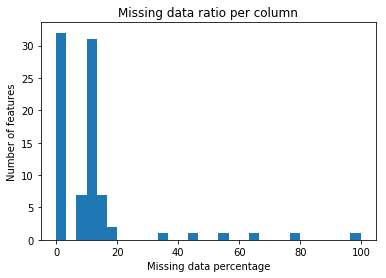

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.figure()
plt.title('Missing data ratio per column')
plt.hist(column_null_proportion['missing_proportion'], bins = 30)
plt.xlabel('Missing data percentage')
plt.ylabel('Number of features')
plt.show()

It seems that a small number of features have a proportion of missing values greater than 20%. Let's check which are these columns.

In [15]:
column_outliers = column_null_proportion[column_null_proportion['missing_proportion'] > 20]
display(column_outliers)

,features,missing_proportion
0,AGER_TYP,76.955435
11,GEBURTSJAHR,44.020282
40,TITEL_KZ,99.757636
43,ALTER_HH,34.813699
47,KK_KUNDENTYP,65.596749
64,KBA05_BAUMAX,53.468668


We'll remove this columns since we could consider them as *outliers columns*.

In [16]:
# Remove the outlier columns from the dataset. (We'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_no_col_outliers = azdias_nan_replaced.drop(columns=column_outliers.features, axis=1)
print('updated dataframe shape:', azdias_no_col_outliers.shape)

updated dataframe shape: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

After replacing missing labels with appropiate Nan values it could be seen that there where a bunch of columns that are mearly unknow.
The criteria for removing some columns was the checking of the histogram generated. For the proyect seems okay to do that (I'll verify that later hopefully), but I think it requires a more indepth analisis about the features.
The removed columns were (alongside are their missing values percentage): 

|   features   | missing_proportion |
| :----------: | :----------------: |
|   AGER_TYP   |     76.955435      |
| GEBURTSJAHR  |     44.020282      |
|   TITEL_KZ   |     99.757636      |
|   ALTER_HH   |     34.813699      |
| KK_KUNDENTYP |     65.596749      |
| KBA05_BAUMAX |     53.468668      |

#### Step 1.1.3: Assess Missing Data in Each **Row**

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. We'll divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We'll select at least five of these columns and compare the distribution of values.
- We can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, we'll write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. 

In [17]:
# How much data is missing in each row of the dataset?
row_null_proportion = pd.DataFrame(azdias_no_col_outliers.isna().mean(axis=1)*100).reset_index()
row_null_proportion.columns = ['rows_idx', 'missing_proportion']
row_null_proportion = row_null_proportion.sort_values(by=['missing_proportion'], ascending=False)
row_null_proportion.set_index('rows_idx', inplace=True, drop=True)
row_null_proportion.head()

,missing_proportion
rows_idx,
732775,62.025316
643174,62.025316
472919,60.759494
345274,59.493671
299868,59.493671


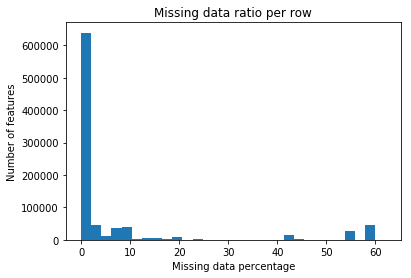

In [18]:
plt.figure()
plt.title('Missing data ratio per row')
plt.hist(row_null_proportion['missing_proportion'], bins = 30)
plt.xlabel('Missing data percentage')
plt.ylabel('Number of features')
plt.show()

It seems that a small number of rows have a proportion of missing values greater than 30%. Let's check these columns.

In [19]:
# Dividing the data into two subsets based on the number of missing values in each row.
rows_outliers = row_null_proportion[row_null_proportion['missing_proportion'] > 30]
display(rows_outliers.head())

,missing_proportion
rows_idx,
732775,62.025316
643174,62.025316
472919,60.759494
345274,59.493671
299868,59.493671


In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
azdias_no_row_outliers = azdias_no_col_outliers.drop(rows_outliers.index, axis=0) 

In [21]:
print('updated dataframe shape:', azdias_no_row_outliers.shape)

updated dataframe shape: (797837, 79)


It is also necesary to handle outliers from each column of the dataset

In [22]:
def mask_outliers(df, prop_threshold):
    """
    Mask the outliers as nans.
    """
    outliers_replaced = []
    df_columns = df.columns.tolist()
    total_records = df.shape[0]
    
    for c in df_columns:
        nulls = df[c].isnull().sum()
        non_nulls = total_records - nulls
        element_proportion_serie = df.groupby(c)[c].count()/non_nulls*100

        element_list = element_proportion_serie.keys().tolist()
        proportion_list = element_proportion_serie.values.tolist()

        # masking values whom proportion is below a threshold
        outlier_elements = [e for e in element_list if element_proportion_serie[e] < prop_threshold]
        for outlier in outlier_elements:
            outliers_replaced.append('outlier: %s, proportion: %s ,column: %s' %(outlier, element_proportion_serie[outlier], c))
            df[c].replace(outlier, np.NaN, inplace = True)

    return df

In [23]:
outlier_threshold = 0.001 # threshold
azdias_clean = mask_outliers(azdias_no_row_outliers, outlier_threshold)

In [24]:
#checking the size of the new dataset without 6 columns
print("number of columns in the final dataset:", azdias_clean.shape[1])
print("number of rows in the original dataset:", df_azdias.shape[0])
print("number of rows in the final dataset:", azdias_clean.shape[0])
print("prop of final dataset with no missing data: {0:.2f}%".format(100*azdias_clean.shape[0]/df_azdias.shape[0]))

number of columns in the final dataset: 79
number of rows in the original dataset: 891221
number of rows in the final dataset: 797837
prop of final dataset with no missing data: 89.52%


#### Discussion 1.1.3: Assess Missing Data in Each Row

The criteria for removing some columns was the checking of the histogram generated. Again, in this scenario it can be seen that the proportion of missing values is above 30 % aprox but I think it requires a more indepth analisis into the business domain to sharp records.

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

We will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

In [25]:
# How many features are there of each data type?
df_feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we'll perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

#### Features comparison between feat_info and azdias dataframes
We could check if all features from feat_info are present in azdias in order to save us time.

In [26]:
feat_info_attribute_list = df_feat_info.attribute.tolist()
azdias_feat_list = azdias_clean.columns.tolist()
f_subset_a = set(feat_info_attribute_list).issubset(azdias_feat_list)
a_subset_f = set(azdias_feat_list).issubset(feat_info_attribute_list)
f_subset_a, a_subset_f

(False, True)

#### Features not present in azdias
Let's check what features are not present in azdias.

In [27]:
feat_not_in_azdias = np.setdiff1d(feat_info_attribute_list, azdias_feat_list).tolist()
print('Features not present in azdias:', feat_not_in_azdias)

Features not present in azdias: ['AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


#### Assessing categorical variables
We need to verify which features are `binary`, which are `multi-level`, and which needs to be re-encoded.

In [28]:
# categorical features
categorical_features_list = df_feat_info[df_feat_info["type"]=="categorical"].attribute.tolist()
categorical_features_list_in_df = [x for x in categorical_features_list if x in azdias_clean.columns.tolist()]

In [29]:
# features
categorical_series = azdias_clean[categorical_features_list_in_df].nunique().sort_values()

In [30]:
categorical_count_df = pd.DataFrame(categorical_series).reset_index()
categorical_count_df.columns=['categorical features', 'number of categories']
categorical_count_df

,categorical features,number of categories
0,ANREDE_KZ,2
1,OST_WEST_KZ,2
2,VERS_TYP,2
3,SOHO_KZ,2
4,GREEN_AVANTGARDE,2
5,NATIONALITAET_KZ,3
6,SHOPPER_TYP,4
7,LP_STATUS_GROB,5
8,LP_FAMILIE_GROB,5
9,FINANZTYP,6


We'll get booleans for filtering between binary and non binary categorical features. False values represent the binary ones.

In [31]:
boolean_not_binary_series = categorical_series > 2 
not_binary_features_list = boolean_not_binary_series[boolean_not_binary_series].index.tolist()

In [32]:
print('No binary_features: ', not_binary_features_list)

No binary_features:  ['NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'FINANZTYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CJT_GESAMTTYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']


In [33]:
# checking what features are present in azdias
set(not_binary_features_list).issubset(azdias_clean.columns)

True

Re-encoding non binary categorical variables to be kept in the analysis.

In [34]:
azdias_encode = pd.get_dummies(azdias_clean, columns = not_binary_features_list)

In [35]:
# checking that not binary categorical features are not present in azdias after encoding
set(not_binary_features_list).issubset(azdias_encode.columns)

False

Unique binary categorical feature with letters

In [36]:
azdias_encode.OST_WEST_KZ.replace({'O': 0, 'W': 1}, inplace=True)

In [37]:
azdias_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

So first it was necesary to identify the categorical features present in the dataset already pre procesed. Then, identify if it was multi or binary categories. For the first type the process is to one hot encode and for the other the only one to be encode was OST_WEST_KZ because it conteined string values.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

`Data_Dictionary.md` private file contains the details needed to finish these tasks. I'll detail the process.

In [38]:
print('Features with mixed type: \n')
df_feat_info[df_feat_info['type'] == 'mixed']

Features with mixed type: 



,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


#### Investigating "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [39]:
print('PRAEGENDE_JUGENDJAHRE unique values list: ', azdias_encode['PRAEGENDE_JUGENDJAHRE'].unique().tolist())

PRAEGENDE_JUGENDJAHRE unique values list:  [14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 9.0, 6.0, 4.0, nan, 2.0, 1.0, 12.0, 13.0, 7.0]


In [40]:
# from the docs PRAEGENDE_JUGENDJAHRE  is condensed in two representative variables: decade and movement

def features_from_PRAEGENDE_JUGENDJAHRE(df):
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), 'DECADE'] = '40s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), 'DECADE'] = '50s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), 'DECADE'] = '60s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), 'DECADE'] = '70s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), 'DECADE'] = '80s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 'DECADE'] = '90s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]), 'MOVEMENT'] = 'Mainstream'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,46,7,9,11,13,15]), 'MOVEMENT'] = 'Avantgarde'
    return df

azdias_PRAEGENDE = features_from_PRAEGENDE_JUGENDJAHRE(azdias_encode)

In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def features_from_CAMEO_INTL_2015(df):
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].astype(float)

    df.loc[df["CAMEO_INTL_2015"] // 10 == 1.0, 'WEALTH'] = 'Wealthy Households'
    df.loc[df["CAMEO_INTL_2015"] // 10 == 2.0, 'WEALTH'] = 'Prosperous Households'
    df.loc[df["CAMEO_INTL_2015"] // 10 == 3.0, 'WEALTH'] = 'Comfortable Households'
    df.loc[df["CAMEO_INTL_2015"] // 10 == 4.0, 'WEALTH'] = 'Less Affluent Households'
    df.loc[df["CAMEO_INTL_2015"] // 10 == 5.0, 'WEALTH'] = 'Poorer Households'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 1.0, 'LIFE_STAGE'] = 'Pre-Family Couples & Singles'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 2.0, 'LIFE_STAGE'] = 'Young Couples With Children'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 3.0, 'LIFE_STAGE'] = 'Families With School Age Children'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 4.0, 'LIFE_STAGE'] = 'Older Families &  Mature Couples'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 5.0, 'LIFE_STAGE'] = 'Elders In Retirement'
    return df


In [42]:
azdias_mixed = features_from_CAMEO_INTL_2015(azdias_PRAEGENDE)

#### Discussion 1.2.2: Engineer Mixed-Type Features

To engineer this mixed types features it was necesary to analize the .md file with the features detail. These two features have data inside so it was necesary to extract it as part of the azdias dataframe columns. The way i've done it is not very fancy but works.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that the data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

We need to make sure that for any new columns that we have engineered, that we've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, we should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features we created should be retained. As a reminder, our data should only be from **the subset with few or no missing values**.

In [43]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# One-hot encode PRAEGENDE_JUGENDJAHRE new features
azdias_mixed_PRAEGENDE_encode = pd.get_dummies(azdias_mixed, columns = ['DECADE', 'MOVEMENT'])
# Drop the original feature
azdias_mixed_PRAEGENDE_encode.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace=True)

In [44]:
# same for CAMEO_INTL_2015 extracted features
azdias_mixed_CAMEO_encode = pd.get_dummies(azdias_mixed_PRAEGENDE_encode, columns = ['WEALTH', 'LIFE_STAGE'])
# Drop the original feature
azdias_mixed_CAMEO_encode.drop('CAMEO_INTL_2015', axis = 1, inplace=True)

In [45]:
azdias_cleaned = azdias_mixed_CAMEO_encode.copy()

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. The function below will be used to execute the main feature selection, encoding, and re-engineering steps we performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

The helper funciton is saved at `clean_data_helper.py` script.

### Saving the cleaned data
Once cleaned the data will be saved in order to save us time later.

In [46]:
# azdias_cleaned.to_csv('azdias_cleaned.csv')

In [47]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WEALTH_Comfortable Households,WEALTH_Less Affluent Households,WEALTH_Poorer Households,WEALTH_Prosperous Households,WEALTH_Wealthy Households,LIFE_STAGE_Elders In Retirement,LIFE_STAGE_Families With School Age Children,LIFE_STAGE_Older Families & Mature Couples,LIFE_STAGE_Pre-Family Couples & Singles,LIFE_STAGE_Young Couples With Children
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,1,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,1,0,0,0,1,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,1,0,0,0,0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,1,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,1,0,0,0,0,1,0,0


In [48]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797837 entries, 1 to 891220
Columns: 209 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_Young Couples With Children
dtypes: float64(41), int64(23), uint8(145)
memory usage: 506.0 MB


In [49]:
%store azdias_cleaned

Stored 'azdias_cleaned' (DataFrame)


In [50]:
del azdias_cleaned